In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
3456,PRV55338,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
32932,BENE131486,CLM46026,2009-04-07,2009-04-08,PRV55691,6000,PHY362055,PHY362055,NaN,2009-04-07,5750,1068.0,2009-04-08,411,5750,V1254,27651,2724,27800,311,7140,NaN,NaN,NaN,5123.0,NaN,NaN,NaN,NaN,NaN


In [6]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
59036,BENE27811,CLM660150,2009-11-01,2009-11-01,PRV55534,200,PHY400378,PHY400378,PHY400378,8760,3182,8509,73300,87320,4299,V5861,29680,41400,2724,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [7]:
# convert dates to datetime format in outpatient
outpatient['ClaimStartDt'] = pd.to_datetime(outpatient['ClaimStartDt'])
outpatient['ClaimEndDt'] = pd.to_datetime(outpatient['ClaimEndDt'])
outpatient['ClaimDuration'] = (outpatient['ClaimEndDt'] - outpatient['ClaimStartDt']).dt.days.astype(int)
outpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration
372034,BENE117547,CLM253194,2009-03-18,2009-03-18,PRV54975,70,PHY388198,NaN,PHY388198,5571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
157552,BENE56237,CLM561332,2009-09-04,2009-09-04,PRV51204,20,PHY360271,NaN,NaN,78609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
123140,BENE46226,CLM599199,2009-09-26,2009-09-26,PRV55969,0,PHY326984,PHY326984,PHY326984,0362,99591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
190983,BENE65826,CLM285256,2009-04-04,2009-04-04,PRV52884,700,PHY405838,PHY405838,NaN,4540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [8]:
outpatient['ClaimDuration'].value_counts()

ClaimDuration
0     453348
20     24312
1      11960
2       4366
14      2735
3       2597
7       2564
4       2238
5       1511
9       1378
6       1306
8       1189
16      1136
10       982
15       975
11       953
13       947
12       903
17       808
18       800
19       727
23         1
21         1
Name: count, dtype: int64

In [9]:
inpatient['Provider'].nunique()

2092

In [10]:
# convert dates to datetime format in Inpatient
inpatient['ClaimStartDt'] = pd.to_datetime(inpatient['ClaimStartDt'])
inpatient['ClaimEndDt'] = pd.to_datetime(inpatient['ClaimEndDt'])
inpatient['ClaimDuration'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days.astype(int)
inpatient.sample(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
27362,BENE111270,CLM33598,2009-01-12,2009-01-14,PRV56647,17000,PHY417592,NaN,NaN,2009-01-12,33392,1068.0,2009-01-14,022,3369,70705,32723,40390,4660,2989,78609,V1254,3572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
33115,BENE132263,CLM75419,2009-11-10,2009-11-11,PRV55443,7000,PHY422255,PHY343694,NaN,2009-11-10,78650,1068.0,2009-11-11,290,41401,4263,2729,V5866,42832,2724,25001,51889,V4582,NaN,3722.0,4019.0,NaN,NaN,NaN,NaN,1
6724,BENE35274,CLM80455,2009-12-22,2009-12-31,PRV53245,11000,PHY354526,NaN,NaN,2009-12-22,71693,1068.0,2009-12-31,517,71536,4254,2761,27549,2410,25000,7837,4019,311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
39784,BENE156771,CLM76556,2009-11-19,2009-12-24,PRV56560,0,PHY347540,PHY363233,PHY430721,2009-11-19,7802,1068.0,2009-12-24,000,5990,42761,2841,25000,34690,53081,42731,4019,2720,NaN,5123.0,NaN,NaN,NaN,NaN,NaN,35


In [11]:
# aggregate inpatient data by provider and create the dataframe
df = inpatient.groupby('Provider').agg(
    IPClaimDurationSum = ('ClaimDuration', 'sum'),
    IPClaimDurationCount = ('ClaimDuration', 'count')
).reset_index()
df

,Provider,IPClaimDurationSum,IPClaimDurationCount
0,PRV51001,25,5
1,PRV51003,320,62
2,PRV51007,16,3
3,PRV51008,8,2
4,PRV51011,5,1
...,...,...,...
2087,PRV57719,55,4
2088,PRV57728,4,1
2089,PRV57729,61,11
2090,PRV57732,58,11


In [12]:
# Check a specefic provider to make sure the number looks good
inpatient.loc[inpatient['Provider'] == 'PRV51001']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimDuration
6904,BENE36012,CLM58316,2009-07-04,2009-07-08,PRV51001,36000,PHY340163,NaN,NaN,2009-07-04,29623,1068.0,2009-07-08,882,29650,2971,3051,V1254,07070,28260,7823,49300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
7611,BENE38773,CLM52334,2009-05-23,2009-05-25,PRV51001,12000,PHY346762,NaN,NaN,2009-05-23,0389,1068.0,2009-05-25,864,0388,5849,2841,2762,7140,E9444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
23936,BENE98831,CLM36844,2009-02-03,2009-02-08,PRV51001,3000,PHY383193,NaN,NaN,2009-02-03,5362,1068.0,2009-02-08,353,56211,5533,0088,5789,53081,27651,7840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
25014,BENE102690,CLM49733,2009-05-04,2009-05-18,PRV51001,42000,PHY383193,PHY378091,PHY389113,2009-05-04,41401,1068.0,2009-05-18,245,4241,42731,4168,2724,4019,42822,2720,45829,53081,NaN,3521.0,2724.0,NaN,NaN,NaN,NaN,14
38474,BENE152088,CLM37205,2009-02-06,2009-02-06,PRV51001,4000,PHY402229,PHY329739,NaN,2009-02-06,80121,1068.0,2009-02-06,062,85222,2724,3310,40390,V4501,V5866,NaN,NaN,NaN,NaN,8659.0,NaN,NaN,NaN,NaN,NaN,0


In [13]:
# Display the datafrom inpatient
df

,Provider,IPClaimDurationSum,IPClaimDurationCount
0,PRV51001,25,5
1,PRV51003,320,62
2,PRV51007,16,3
3,PRV51008,8,2
4,PRV51011,5,1
...,...,...,...
2087,PRV57719,55,4
2088,PRV57728,4,1
2089,PRV57729,61,11
2090,PRV57732,58,11


In [14]:
# Make sure I have the correct number of unique providers from outpatient
outpatient['Provider'].nunique()

5012

In [15]:
# aggregate outpatient data by provider and create the dataframe
out_df = outpatient.groupby('Provider').agg(
    OPClaimDurationSum = ('ClaimDuration', 'sum'),
    OPClaimDurationCount = ('ClaimDuration', 'count')
).reset_index()
out_df

,Provider,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,11,20
1,PRV51003,165,70
2,PRV51004,213,149
3,PRV51005,1268,1165
4,PRV51007,53,69
...,...,...,...
5007,PRV57759,60,28
5008,PRV57760,7,22
5009,PRV57761,114,82
5010,PRV57762,0,1


In [16]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left
    out_df,  # Right
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [17]:
# The full data before modeling
provider_claims

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,25.0,5.0,11.0,20.0
1,PRV51003,320.0,62.0,165.0,70.0
2,PRV51004,0.0,0.0,213.0,149.0
3,PRV51005,0.0,0.0,1268.0,1165.0
4,PRV51007,16.0,3.0,53.0,69.0
...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0
5406,PRV57760,0.0,0.0,7.0,22.0
5407,PRV57761,0.0,0.0,114.0,82.0
5408,PRV57762,0.0,0.0,0.0,1.0


In [18]:
# # # Save selected columns to CSV
# provider_claims.to_csv('6 draft.csv', index=False)

In [19]:
provider_claims['IPClaimDurationSum'].sum()

np.float64(229093.0)

In [20]:
provider_claims['OPClaimDurationSum'].sum()

np.float64(735462.0)

In [21]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [22]:
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,No
1,PRV51003,320.0,62.0,165.0,70.0,Yes
2,PRV51004,0.0,0.0,213.0,149.0,No
3,PRV51005,0.0,0.0,1268.0,1165.0,Yes
4,PRV51007,16.0,3.0,53.0,69.0,No
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0,No
5406,PRV57760,0.0,0.0,7.0,22.0,No
5407,PRV57761,0.0,0.0,114.0,82.0,No
5408,PRV57762,0.0,0.0,0.0,1.0,No


In [23]:
# make the potential fraud column binary
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,25.0,5.0,11.0,20.0,0
1,PRV51003,320.0,62.0,165.0,70.0,1
2,PRV51004,0.0,0.0,213.0,149.0,0
3,PRV51005,0.0,0.0,1268.0,1165.0,1
4,PRV51007,16.0,3.0,53.0,69.0,0
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.0,60.0,28.0,0
5406,PRV57760,0.0,0.0,7.0,22.0,0
5407,PRV57761,0.0,0.0,114.0,82.0,0
5408,PRV57762,0.0,0.0,0.0,1.0,0


In [24]:
# Select the features
X = final_df[['IPClaimDurationSum',
              'IPClaimDurationCount',
              'OPClaimDurationSum',
              'OPClaimDurationCount']]

In [25]:
# Select the target
y = final_df['PotentialFraud']

In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [27]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [28]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [29]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)


In [30]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix before manipulating by adjusting the threshold\nConfusion Matrix:")
print(cm)

Confusion Matrix before manipulating by adjusting the threshold
Confusion Matrix:
[[964  13]
 [ 65  40]]


In [31]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.38
F1 Score: 0.51


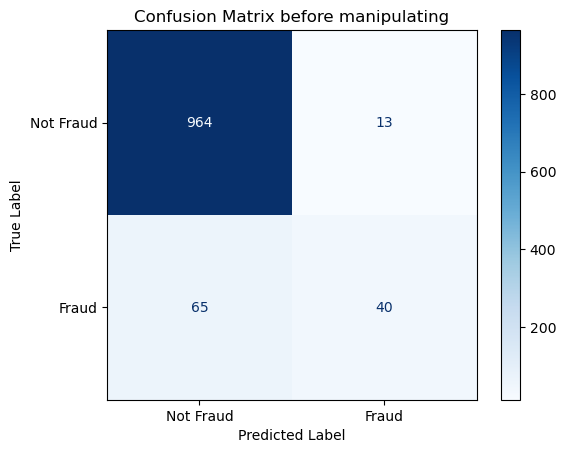

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix before manipulating')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

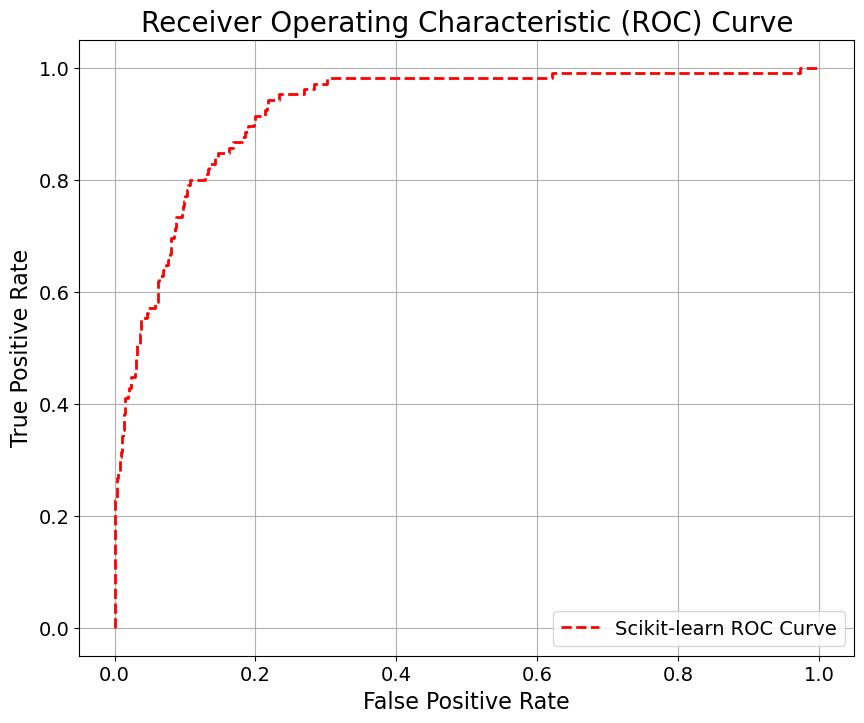

In [33]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [34]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9239362479894722)

In [80]:
# df = df.merge(train, how='left', on='Provider')

In [81]:
# df

In [82]:
# df['PotentialFraud'] = df['PotentialFraud'].map({'Yes': 1, 'No': 0})
# df

In [83]:
# # feature total amount reimbursed by by the insurance per provider:
# X = df[['IPReimbursmentTotal']]
# X


In [84]:
# # target value (True or False), when 1 == Yes, and 0 == No.
# y = df['PotentialFraud']
# y

In [85]:
# # 1. Split the data: 80% for training, 20% for testing.
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [86]:
# # 2. Scale the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [87]:
# # 3. Fit the model
# model = LogisticRegression()
# model.fit(X_train, y_train)

In [88]:
# # 4. Make prediction on the test 
# y_pred = model.predict(X_test)

In [89]:
# cm = confusion_matrix(y_test, y_pred)
# print(f'Confusion Matrix:\n{cm}')

In [90]:
# from sklearn.metrics import  precision_score, recall_score, f1_score
# accuracy = accuracy_score(y_test, y_pred)
# precicion = precision_score(y_test, y_pred)
# recall = recall_score(y_test,y_pred)
# f1 = f1_score(y_test,y_pred)
# print(f'Accuracy: {accuracy:.2}')
# print(f'precision: {precicion:.2}')
# print(f'recall: {recall:.2}')
# print(f'f1 score: {f1:.2}')

In [91]:
# X_test

# Loooking for a better threshold to find the best F1-score:

In [ ]:
# # Get predicted probabilities
# y_proba = model.predict_proba(X_test)[:, 1]

In [37]:
# precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
# best_threshold = thresholds[f1_scores.argmax()]
# print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.16017099642040386


In [38]:
# # apply the new best threshold to the predicted probabilities
# y_pred_custom = (y_proba >= best_threshold).astype(int)
# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred_custom)
# print("After processing the best threshold for the highest F1-score, \nHere is the Confusion Matrix:\n", cm)

After processing the best threshold for the highest F1-score, 
Here is the Confusion Matrix:
 [[940  37]
 [ 47  58]]


In [39]:
# # flatten the confusion matrix and break it down into four components.
# TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix AFTER manipulating by adding the threshold:\n')
# # Calculating metrics
# accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
# print(f'Accuracy: {accuracy:.2f}')
# precision = TP / (TP + FP) if (TP + FP) != 0 else 0
# print(f'Precision: {precision:.2f}')
# recall = TP / (TP + FN) if (TP + FN) != 0 else 0
# print(f'Recall: {recall:.2f}')
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
# print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix AFTER manipulating by adding the threshold:

Accuracy: 0.92
Precision: 0.61
Recall: 0.55
F1 Score: 0.58


# Applying Cross Validation

In [35]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
# Also looking for the best "roc_auc"
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean roc_auc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94274886 0.94692222 0.91942451 0.93674872 0.93632453]
Mean roc_auc: 0.9364


In [36]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9390


In [37]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)

              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.81      0.28      0.41       105

    accuracy                           0.92      1082
   macro avg       0.87      0.63      0.69      1082
weighted avg       0.92      0.92      0.91      1082



In [38]:
#  Grid search for best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)


In [ ]:
# from sklearn.metrics import make_scorer, fbeta_score
# custom_scorer = make_scorer(fbeta_score, beta=2)


In [39]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
model = LogisticRegression(max_iter=10000)

# Use GridSearchCV with the custom scorer
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters & best F-beta score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC_AUC: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC_AUC: 0.9390


# SMOTE

In [40]:
from imblearn.over_sampling import SMOTE

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [41]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [42]:
# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


I'm

In [43]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for roc_auc
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [44]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9610


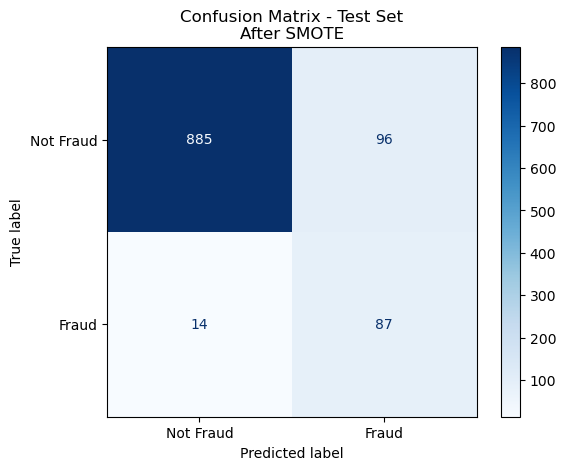

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set\nAfter SMOTE")
plt.show()


In [46]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\nAfter SMOTE:")
print(cm)

Confusion Matrix
After SMOTE:
[[885  96]
 [ 14  87]]


In [47]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('All scores after SMOTE:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

All scores after SMOTE:

Accuracy: 0.90
Precision: 0.48
Recall: 0.86
F1 Score: 0.61


In [48]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9610


In [49]:
X

,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
0,25.0,5.0,11.0,20.0
1,320.0,62.0,165.0,70.0
2,0.0,0.0,213.0,149.0
3,0.0,0.0,1268.0,1165.0
4,16.0,3.0,53.0,69.0
...,...,...,...,...
5405,0.0,0.0,60.0,28.0
5406,0.0,0.0,7.0,22.0
5407,0.0,0.0,114.0,82.0
5408,0.0,0.0,0.0,1.0


In [50]:
X_train_resampled

,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
0,0.000000,0.000000,168.000000,105.000000
1,0.000000,0.000000,8.000000,14.000000
2,0.000000,0.000000,122.000000,144.000000
3,82.000000,15.000000,32.000000,9.000000
4,236.000000,47.000000,20.000000,41.000000
...,...,...,...,...
7841,0.000000,0.000000,453.223556,148.199932
7842,0.000000,0.000000,499.563993,481.872013
7843,174.831910,33.755176,0.000000,0.000000
7844,52.099141,7.585592,0.000000,0.000000
